In [ ]:
from __future__ import annotations

import os
import random
import hashlib
from pathlib import Path
from typing import List, Tuple, Dict, Optional, Set
import soundfile as sf
from tqdm import tqdm

import numpy as np
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torchaudio
from torchvision.transforms.functional import resize
import torch.nn.functional as F
import torchvision.models as models
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Hyperparams
TARGET_SR = 16000
CLIP_SECONDS = 3.0
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

# --- Audio Loading & Preprocessing ---
def load_wav(path: Path) -> tuple[torch.Tensor, int]:
    wav_np, sr = sf.read(str(path), dtype="float32", always_2d=True)  # [T, C]
    wav = torch.from_numpy(wav_np).transpose(0, 1).contiguous()       # -> [C, T]
    return wav, int(sr)

def ensure_mono_t(wav: torch.Tensor) -> torch.Tensor:
    if wav.ndim == 2:
        if wav.size(0) == 1:
            return wav[0]
        return wav.mean(dim=0)
    return wav

def pad_or_trim_t(wav: torch.Tensor, target_len: int) -> torch.Tensor:
    n = wav.shape[0]
    if n > target_len:
        return wav[:target_len]
    if n < target_len:
        pad = torch.zeros(target_len - n, dtype=wav.dtype)
        return torch.cat([wav, pad], dim=0)
    return wav

def _check_min_counts_per_class(class_to_indices: Dict[int, List[int]], need_train: bool, need_val: bool, need_test: bool):
    required = int(need_train) + int(need_val) + int(need_test)
    for cls, idxs in class_to_indices.items():
        if len(idxs) < required:
            raise ValueError(
                f"Class id {cls} has only {len(idxs)} files; need at least {required} "
                f"to guarantee presence in all splits. Add more data or relax the constraint."
            )

def _stratified_split_indices(
    labels: List[int],
    train_ratio: float = 0.8,
    val_ratio: float = 0.1,
    test_ratio: float = 0.1,
    seed: int = 42,
    require_all_in_train_val_test: bool = True,
) -> Tuple[List[int], List[int], List[int]]:
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6

    class_to_indices: Dict[int, List[int]] = {}
    for i, y in enumerate(labels):
        class_to_indices.setdefault(y, []).append(i)

    if require_all_in_train_val_test:
        _check_min_counts_per_class(class_to_indices, True, True, True)

    g = torch.Generator().manual_seed(seed)

    train_idx, val_idx, test_idx = [], [], []
    for cls, idxs in class_to_indices.items():
        perm = torch.randperm(len(idxs), generator=g).tolist()
        idxs = [idxs[i] for i in perm]

        n = len(idxs)
        n_val = max(1, int(round(n * val_ratio)))
        n_test = max(1, int(round(n * test_ratio)))

        if n_val + n_test > n - 1:
            spill = (n_val + n_test) - (n - 1)
            for _ in range(spill):
                if n_val >= n_test and n_val > 1:
                    n_val -= 1
                elif n_test > 1:
                    n_test -= 1
            if n_val + n_test > n - 1:
                n_val, n_test = 1, 1

        n_train = n - n_val - n_test
        if require_all_in_train_val_test:
            if n_train < 1 or n_val < 1 or n_test < 1:
                raise ValueError(f"Class {cls}: cannot allocate at least 1 sample to each split with n={n}.")

        cls_val = idxs[:n_val]
        cls_test = idxs[n_val:n_val + n_test]
        cls_train = idxs[n_val + n_test:]

        val_idx.extend(cls_val)
        test_idx.extend(cls_test)
        train_idx.extend(cls_train)

    return train_idx, val_idx, test_idx

# --- Data Augmentation ---
class SpecAugment(torch.nn.Module):
    def __init__(self, freq_mask_param=40, time_mask_param=80, num_freq_masks=2, num_time_masks=2):
        super().__init__()
        self.freq_mask_param = freq_mask_param
        self.time_mask_param = time_mask_param
        self.num_freq_masks = num_freq_masks
        self.num_time_masks = num_time_masks

    def forward(self, spec: torch.Tensor) -> torch.Tensor:
        for _ in range(self.num_freq_masks):
            spec = torchaudio.transforms.FrequencyMasking(freq_mask_param=self.freq_mask_param)(spec)
        for _ in range(self.num_time_masks):
            spec = torchaudio.transforms.TimeMasking(time_mask_param=self.time_mask_param)(spec)
        return spec

class TimeStretch(torch.nn.Module):
    def __init__(self, stretch_factor_min=0.8, stretch_factor_max=1.2):
        super().__init__()
        self.stretch_factor_min = stretch_factor_min
        self.stretch_factor_max = stretch_factor_max

    def forward(self, spec: torch.Tensor) -> torch.Tensor:
        factor = random.uniform(self.stretch_factor_min, self.stretch_factor_max)
        time_dim = spec.size(-1)
        new_time = int(time_dim * factor)
        if new_time != time_dim:
            spec = resize(spec.unsqueeze(0), [spec.size(1), new_time], antialias=True).squeeze(0)
        return spec

class AddNoise(torch.nn.Module):
    def __init__(self, snr_db_min=20, snr_db_max=40):
        super().__init__()
        self.snr_db_min = snr_db_min
        self.snr_db_max = snr_db_max

    def forward(self, spec: torch.Tensor) -> torch.Tensor:
        noise = torch.randn_like(spec) * 0.01
        signal_power = spec.pow(2).mean()
        noise_power = noise.pow(2).mean()
        snr_db = random.uniform(self.snr_db_min, self.snr_db_max)
        snr_linear = 10 ** (snr_db / 10)
        scale = (signal_power / (snr_linear * noise_power)).sqrt()
        noise = noise * scale
        return spec + noise

# --------------- Dataset (with cache-on-first-use + exclude) ----------------
class AudioFolderMelDataset(Dataset):
    def __init__(
        self,
        root: str | Path,
        target_sr: int = TARGET_SR,
        clip_seconds: float = CLIP_SECONDS,
        extensions: Tuple[str, ...] = (".wav", ".flac", ".ogg"),
        sort_files: bool = True,
        # Mel params
        n_mels: int = 128,
        n_fft: int = 1024,
        hop_length: int = 256,
        f_min: float = 0.0,
        f_max: Optional[float] = None,
        # Output shape controls
        channels: int = 3,
        as_image: bool = True,
        image_size: int = 224,
        # Normalization
        per_image_minmax: bool = False,
        use_imagenet_norm: bool = False,
        # Global stats
        global_mean: Optional[float] = None,
        global_std: Optional[float] = None,
        # Augmentation (train only)
        augment: bool = False,
        # Cache
        cache_root: Optional[str | Path] = None,
        exclude_classes: Optional[Set[str]] = None,
         cache_version: str = "v1"
    ):
        self.root = Path(root)
        self.target_sr = int(target_sr)
        self.clip_seconds = float(clip_seconds)
        self.target_len = int(self.target_sr * self.clip_seconds)
        self.extensions = tuple(e.lower() for e in extensions)
        self.augment = augment
        self.exclude_classes = set(exclude_classes or [])
        self.cache_version = cache_version

        class_dirs = [p for p in self.root.iterdir() if p.is_dir() and p.name not in self.exclude_classes]  # NEW
        if not class_dirs:
            raise RuntimeError(f"No class folders found in {self.root} after excluding {self.exclude_classes}")
        class_dirs.sort(key=lambda p: p.name)

        self.classes: List[str] = [p.name for p in class_dirs]
        self.label2id: Dict[str, int] = {c: i for i, c in enumerate(self.classes)}
        self.id2label: Dict[int, str] = {i: c for c, i in self.label2id.items()}

        items: List[Tuple[Path, int]] = []
        for cdir in class_dirs:
            label_id = self.label2id[cdir.name]
            files = [f for f in cdir.glob("*") if f.is_file() and f.suffix.lower() in self.extensions]
            if sort_files:
                files.sort()
            items.extend((f, label_id) for f in files)

        if not items:
            raise RuntimeError(f"No audio files with {self.extensions} found in {self.root}")

        self.items: List[Tuple[Path, int]] = items

       
        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=self.target_sr,
            n_fft=n_fft,
            win_length=int(0.025 * self.target_sr),  
            hop_length=hop_length,                     
            n_mels=n_mels,
            f_min=0.0,
            f_max=(self.target_sr / 2.0) - 1.0,
            power=2.0,
            norm="slaney",                                 
            mel_scale="slaney", 
        )

        
        def _to_logmel(x: torch.Tensor) -> torch.Tensor:
            return torch.log(x.clamp_min(1e-10))
        self._to_logmel = _to_logmel


        # output controls
        assert channels in (1, 3), "channels must be 1 or 3"
        self.channels = channels
        self.as_image = as_image
        self.image_size = int(image_size)
        self.per_image_minmax = per_image_minmax
        self.use_imagenet_norm = use_imagenet_norm and (channels == 3)

        self.global_mean = global_mean
        self.global_std = global_std

        # Augmentation
        if augment:
            self.spec_augment = SpecAugment()
            self.time_stretch = TimeStretch()
            self.add_noise = AddNoise()

        # Cache parameters
        self.cache_root = Path(cache_root) if cache_root is not None else None
        if self.cache_root is not None:
            self.cache_ns = self._cache_namespace(
                n_mels=n_mels, n_fft=n_fft, hop_length=hop_length,
                channels=channels, image_size=image_size,
                per_image_minmax=per_image_minmax,
                use_imagenet_norm=use_imagenet_norm,
                target_sr=self.target_sr, clip_seconds=self.clip_seconds,
                excluded=",".join(sorted(self.exclude_classes)),
                cache_version=self.cache_version,
            )
            (self.cache_root / self.cache_ns).mkdir(parents=True, exist_ok=True)

    def _cache_namespace(self, **kwargs) -> str:
        key = "|".join(f"{k}={v}" for k, v in sorted(kwargs.items()))
        h = hashlib.md5(key.encode()).hexdigest()[:10]
        return f"melcache_{h}"

    def _cache_path_for(self, audio_path: Path, label_id: int) -> Optional[Path]:
        if self.cache_root is None:
            return None
        cls_name = self.id2label[label_id]
        dest_dir = self.cache_root / self.cache_ns / cls_name
        dest_dir.mkdir(parents=True, exist_ok=True)
        return dest_dir / (audio_path.stem + ".pt")

    def __len__(self) -> int:
        return len(self.items)

    def compute_global_stats(self, num_samples: int = 500) -> Tuple[float, float]:
        print(f"Computing global statistics from {num_samples} samples...")
        old_per_image = self.per_image_minmax
        old_use_imagenet = self.use_imagenet_norm
        self.per_image_minmax = False
        self.use_imagenet_norm = False

        specs = []
        indices = np.random.choice(len(self), min(num_samples, len(self)), replace=False)
        for idx in indices:
            spec, _ = self[idx]
            specs.append(spec)

        all_specs = torch.stack(specs)
        self.global_mean = all_specs.mean().item()
        self.global_std = all_specs.std().item()

        self.per_image_minmax = old_per_image
        self.use_imagenet_norm = old_use_imagenet

        print(f"Global mean: {self.global_mean:.4f}, std: {self.global_std:.4f}")
        return self.global_mean, self.global_std

    @torch.no_grad()
    def _waveform_to_spec(self, wav: torch.Tensor, apply_augment: bool = False) -> torch.Tensor:
        if wav.ndim == 1:
            wav = wav.unsqueeze(0)

        mel = self.melspec(wav)
        mel_log = self._to_logmel(mel)

        if self.channels == 1:
            spec = mel_log
        else:
            delta  = torchaudio.functional.compute_deltas(mel_log)
            delta2 = torchaudio.functional.compute_deltas(delta)
            spec = torch.cat([mel_log, delta, delta2], dim=0)

        spec = spec.squeeze(1).to(torch.float32)

        if apply_augment and self.augment:
            spec = self.time_stretch(spec)
            spec = self.add_noise(spec)
            spec = self.spec_augment(spec)

        if self.global_mean is not None and self.global_std is not None:
            spec = (spec - self.global_mean) / (self.global_std + 1e-8)
        elif self.per_image_minmax:
            ch_min = spec.amin(dim=(1, 2), keepdim=True)
            ch_max = spec.amax(dim=(1, 2), keepdim=True)
            spec = (spec - ch_min) / (ch_max - ch_min + 1e-8)

        if self.as_image:
            h, w = spec.shape[-2], spec.shape[-1]
            if h > w:
                new_w = int(w * self.image_size / h)
                spec = resize(spec.unsqueeze(0), [self.image_size, new_w], antialias=True).squeeze(0)
                pad = self.image_size - new_w
                spec = F.pad(spec, (0, pad, 0, 0), mode='constant', value=0)
            else:
                new_h = int(h * self.image_size / w)
                spec = resize(spec.unsqueeze(0), [new_h, self.image_size], antialias=True).squeeze(0)
                pad = self.image_size - new_h
                spec = F.pad(spec, (0, 0, 0, pad), mode='constant', value=0)

        if self.use_imagenet_norm:
            spec = (spec - IMAGENET_MEAN) / IMAGENET_STD

        return spec

    def __getitem__(self, idx: int):
        path, label = self.items[idx]
        cpath = self._cache_path_for(path, label)

        if cpath is not None and cpath.exists():
            obj = torch.load(cpath, map_location="cpu")
            spec = obj["spec"]
            if self.augment:
                spec = self.spec_augment(spec)  
            return spec, label

        wav, sr = load_wav(path)
        wav = ensure_mono_t(wav)
        if sr != self.target_sr:
            wav = torchaudio.functional.resample(wav, sr, self.target_sr)
        wav = pad_or_trim_t(wav, self.target_len)

        if self.augment:
            shift = int(random.uniform(-0.1, 0.1) * self.target_len)
            if   shift > 0: wav = torch.cat([wav[shift:], torch.zeros(shift, dtype=wav.dtype)])
            elif shift < 0: wav = torch.cat([torch.zeros(-shift, dtype=wav.dtype), wav[:shift]])

        spec = self._waveform_to_spec(wav, apply_augment=self.augment)

        if cpath is not None:
            torch.save({"spec": spec, "src": str(path)}, cpath)

        return spec, label


    @staticmethod
    def make_dataloaders(
        root: str | Path,
        batch_size: int = 32,
        num_workers: int = os.cpu_count() or 4,
        pin_memory: bool = True,
        train_ratio: float = 0.8,
        val_ratio: float = 0.1,
        test_ratio: float = 0.1,
        seed: int = 42,
        n_mels: int = 128,
        n_fft: int = 1024,
        hop_length: int = 256,
        channels: int = 3,
        as_image: bool = True,
        image_size: int = 224,
        per_image_minmax: bool = False,
        use_imagenet_norm: bool = False,
        compute_global_stats: bool = True,
        stats_samples: int = 500,
        augment_train: bool = True,
        cache_root: Optional[str | Path] = None,
        exclude_classes: Optional[Set[str]] = None,   
    ) -> Tuple[DataLoader, DataLoader, DataLoader, Dict[int, str], Dict[str, int]]:

        full_ds = AudioFolderMelDataset(
            root=root,
            target_sr=TARGET_SR,
            clip_seconds=CLIP_SECONDS,
            n_mels=n_mels,
            n_fft=n_fft,
            hop_length=hop_length,
            channels=channels,
            as_image=as_image,
            image_size=image_size,
            per_image_minmax=per_image_minmax,
            use_imagenet_norm=use_imagenet_norm,
            cache_root=None,                 
            exclude_classes=exclude_classes, 
        )

        if compute_global_stats:
            print("Computing global statistics for normalization...")
            full_ds.compute_global_stats(num_samples=stats_samples)

        labels = [lbl for _, lbl in full_ds.items]

        train_idx, val_idx, test_idx = _stratified_split_indices(
            labels=labels,
            train_ratio=train_ratio,
            val_ratio=val_ratio,
            test_ratio=test_ratio,
            seed=seed,
            require_all_in_train_val_test=True,
        )

        base_kwargs = dict(
            root=root, 
            target_sr=TARGET_SR,
            clip_seconds=CLIP_SECONDS,
            n_mels=n_mels,
            n_fft=n_fft,
            hop_length=hop_length,
            channels=channels,
            as_image=as_image,
            image_size=image_size,
            per_image_minmax=per_image_minmax,
            use_imagenet_norm=use_imagenet_norm,
            global_mean=full_ds.global_mean,
            global_std=full_ds.global_std,                  
            exclude_classes=exclude_classes,        
        )

        train_ds = AudioFolderMelDataset(**base_kwargs, augment=augment_train,cache_root=None, cache_version = "v3")
        train_ds.items = [full_ds.items[i] for i in train_idx]

        val_ds = AudioFolderMelDataset(**base_kwargs, augment=False,cache_root=cache_root, cache_version = "v3")
        val_ds.items = [full_ds.items[i] for i in val_idx]

        test_ds = AudioFolderMelDataset(**base_kwargs, augment=False,cache_root=cache_root, cache_version = "v3")
        test_ds.items = [full_ds.items[i] for i in test_idx]

        train_loader = DataLoader(
            train_ds, batch_size=batch_size, shuffle=True,
            num_workers=num_workers, pin_memory=pin_memory
        )
        val_loader = DataLoader(
            val_ds, batch_size=batch_size, shuffle=False,
            num_workers=num_workers, pin_memory=pin_memory
        )
        test_loader = DataLoader(
            test_ds, batch_size=batch_size, shuffle=False,
            num_workers=num_workers, pin_memory=pin_memory
        )

        return train_loader, val_loader, test_loader, full_ds.id2label, full_ds.label2id


In [ ]:
#call to compute stats
_ = AudioFolderMelDataset.make_dataloaders(
    root="D:/Repos/sentiotech/extracted",
    cache_root=None,
    batch_size=32,
    num_workers=0,
    per_image_minmax=False,
    use_imagenet_norm=False,
    compute_global_stats=True,
    augment_train=False,
    exclude_classes={"UNMAPPED"},
    n_mels=128,
    n_fft=512,                    
    hop_length=160,                 
)

# loader call
train_loader, val_loader, test_loader, id2label, label2id = AudioFolderMelDataset.make_dataloaders(
    root="D:/Repos/sentiotech/extracted",
    cache_root="D:/Repos/sentiotech/mel_cache",
    batch_size=32,
    num_workers=0,
    per_image_minmax=False,
    use_imagenet_norm=False,
    compute_global_stats=False,
    augment_train=True,
    exclude_classes={"UNMAPPED"},
    n_mels=128,
    n_fft=512,                    
    hop_length=160,                 
)


Computing global statistics for normalization...
Computing global statistics from 500 samples...
Global mean: -1.8999, std: 5.2005


In [ ]:
# ---------- reproducibility ----------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# ---------- weights resolver (works with older/newer torchvision) ----------
def _resolve_efficientnet_weights(weights):
    try:
        return getattr(models, "EfficientNet_B0_Weights").IMAGENET1K_V1 if weights=="IMAGENET1K_V1" else weights
    except Exception:
        return weights

class EfficientNetB0(nn.Module):
    def __init__(
        self,
        in_channels: int = 3,
        num_classes: int = 6,
        weights="IMAGENET1K_V1",
        freeze_backbone: bool = False,
        freeze_until: Optional[int] = None,
        dropout_rate: float = 0.3,
    ):
        super().__init__()
        weights = _resolve_efficientnet_weights(weights)
        self.efficientnet = models.efficientnet_b0(weights=weights)

        if in_channels != 3:
            self.efficientnet.features[0][0] = nn.Conv2d(
                in_channels, 32, kernel_size=3, stride=2, padding=1, bias=False
            )

        in_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features, num_classes)
        )

        if freeze_backbone:
            for p in self.efficientnet.features.parameters(): p.requires_grad = False
        elif freeze_until is not None:
            for i, block in enumerate(self.efficientnet.features):
                if i < freeze_until:
                    for p in block.parameters(): p.requires_grad = False

    def forward(self, x): return self.efficientnet(x)
    def get_trainable_params(self): return [p for p in self.parameters() if p.requires_grad]


def mixup(x, y, alpha=0.2):
    if alpha <= 0: return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    x_mix = lam * x + (1 - lam) * x[idx]
    return x_mix, y, y[idx], lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ---------- training/eval for a small proper run ----------
def train(
    model: nn.Module,
    train_loader,
    val_loader,
    id2label: Dict[int, str],
    device: torch.device,
    epochs: int = 3,
    lr: float = 3e-4,
    weight_decay: float = 1e-4,
    label_smoothing: float = 0.1,
    patience: int = 2,
    use_mixup: bool = True,
    mixup_alpha: float = 0.2,
):
    model = model.to(device).to(memory_format=torch.channels_last)
    torch.backends.cudnn.benchmark = True

    scaler = torch.amp.GradScaler("cuda", enabled=(device.type=="cuda"))
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    optimizer = torch.optim.AdamW(model.get_trainable_params(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, epochs))

    target_names = [id2label[i] for i in range(len(id2label))]
    best_val_acc, best_state, no_improve = 0.0, None, 0
    history = {
        "epoch": [],
        "train_loss": [], "train_acc": [], "train_f1": [],
        "val_loss":   [], "val_acc":   [], "val_f1":   [],
        "lr": [],
    }
    for epoch in range(1, epochs+1):
        # ----- TRAIN -----
        model.train()
        train_loss, train_preds, train_labels = 0.0, [], []
        for x, y in tqdm(train_loader, desc=f"Train Epoch {epoch}"):
            x = x.to(device, non_blocking=True).to(memory_format=torch.channels_last)
            y = y.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            if use_mixup:
                x_mix, y_a, y_b, lam = mixup(x, y, alpha=mixup_alpha)
                with torch.amp.autocast("cuda", enabled=(device.type=="cuda")):
                    logits = model(x_mix)
                    loss = mixup_criterion(criterion, logits, y_a, y_b, lam)
            else:
                with torch.amp.autocast("cuda", enabled=(device.type=="cuda")):
                    logits = model(x)
                    loss = criterion(logits, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            train_preds.extend(logits.argmax(1).detach().cpu().numpy())
            train_labels.extend(y.detach().cpu().numpy())

        train_acc = accuracy_score(train_labels, train_preds)
        train_f1  = f1_score(train_labels, train_preds, average="weighted")

        # ----- VALIDATE -----
        model.eval()
        val_loss, val_preds, val_labels = 0.0, [], []
        with torch.no_grad(), torch.amp.autocast("cuda", enabled=(device.type=="cuda")):
            for x, y in tqdm(val_loader, desc="Validate"):
                x = x.to(device, non_blocking=True).to(memory_format=torch.channels_last)
                y = y.to(device, non_blocking=True)
                logits = model(x)
                loss = criterion(logits, y)
                val_loss += loss.item()
                val_preds.extend(logits.argmax(1).detach().cpu().numpy())
                val_labels.extend(y.detach().cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        val_f1  = f1_score(val_labels, val_preds, average="weighted")

        print("\n--- Per-Class Metrics (Validation) ---")
        print(classification_report(val_labels, val_preds,
                                    target_names=target_names,
                                    digits=4, zero_division=0))
        print(f"Epoch {epoch}: "
              f"Train Loss {train_loss/len(train_loader):.4f} | Acc {train_acc:.4f} | F1 {train_f1:.4f} || "
              f"Val Loss {val_loss/len(val_loader):.4f} | Acc {val_acc:.4f} | F1 {val_f1:.4f}")

        current_lr = next((pg["lr"] for pg in optimizer.param_groups), lr)
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss   = val_loss   / len(val_loader)
        
        history["epoch"].append(epoch)
        history["train_loss"].append(avg_train_loss)
        history["train_acc"].append(train_acc)
        history["train_f1"].append(train_f1)
        history["val_loss"].append(avg_val_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)
        history["lr"].append(current_lr)
        
        scheduler.step()

        # early stopping by val_acc
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            torch.save(best_state, "best_model.pth")
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print("Early stopping.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, best_val_acc, history


def evaluate(model, loader, id2label, device, title="Test"):
    model.eval()
    preds, labels = [], []
    with torch.no_grad(), torch.amp.autocast("cuda", enabled=(device.type=="cuda")):
        for x, y in tqdm(loader, desc=title):
            x = x.to(device).to(memory_format=torch.channels_last)
            y = y.to(device)
            p = model(x).argmax(1)
            preds.extend(p.detach().cpu().numpy())
            labels.extend(y.detach().cpu().numpy())

    acc = accuracy_score(labels, preds)
    f1  = f1_score(labels, preds, average="weighted")
    print(f"\n{title} Acc: {acc:.4f} | F1: {f1:.4f}")
    print("\n--- Per-Class Metrics ("+title+") ---")
    print(classification_report(labels, preds,
                                target_names=[id2label[i] for i in range(len(id2label))],
                                digits=4, zero_division=0))
    return acc, f1

# ---------- run it ----------
# --- model build + load checkpoint ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EfficientNetB0(
    in_channels=3,
    num_classes=len(id2label),
    weights="IMAGENET1K_V1",              
    freeze_backbone=False,
    freeze_until=None,         
    dropout_rate=0.5,
)

state = torch.load("best_model.pth", map_location="cpu")
model.load_state_dict(state)   

for p in model.parameters():
    p.requires_grad = True     


model, best_val_acc, history = train(
    model = model,
    train_loader=train_loader,
    val_loader=val_loader,
    id2label=id2label,
    device=device,
    epochs = 40,
    lr = 1e-4,
    weight_decay = 1e-4,
    label_smoothing =  0.11,
    patience = 7,
    use_mixup = True,
    mixup_alpha = 0.2
)
import pandas as pd
pd.DataFrame(history).to_csv("training_history.csv", index=False)

_ = evaluate(model, test_loader, id2label, device, title="Test")



Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [02:18<00:00,  3.85s/it]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.5734    0.8750    0.6928       192
         DIS     0.7978    0.3698    0.5053       192
         FEA     0.4603    0.7240    0.5628       192
         HAP     0.5614    0.5000    0.5289       192
         NEU     0.6547    0.4764    0.5515       191
         SAD     0.7261    0.5938    0.6533       192

    accuracy                         0.5899      1151
   macro avg     0.6289    0.5898    0.5824      1151
weighted avg     0.6289    0.5899    0.5825      1151

Epoch 1: Train Loss 1.5636 | Acc 0.3051 | F1 0.3021 || Val Loss 1.2674 | Acc 0.5899 | F1 0.5825


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:26<00:00,  1.35it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.8146    0.7552    0.7838       192
         DIS     0.5707    0.6094    0.5894       192
         FEA     0.6970    0.5990    0.6443       192
         HAP     0.5773    0.6615    0.6165       192
         NEU     0.6782    0.6178    0.6466       191
         SAD     0.6268    0.6823    0.6534       192

    accuracy                         0.6542      1151
   macro avg     0.6608    0.6542    0.6557      1151
weighted avg     0.6607    0.6542    0.6557      1151

Epoch 2: Train Loss 1.4435 | Acc 0.3292 | F1 0.3273 || Val Loss 1.1666 | Acc 0.6542 | F1 0.6557


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 18.46it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.6748    0.8646    0.7580       192
         DIS     0.5980    0.6198    0.6087       192
         FEA     0.7083    0.6198    0.6611       192
         HAP     0.6050    0.6302    0.6173       192
         NEU     0.6485    0.6859    0.6667       191
         SAD     0.8015    0.5677    0.6646       192

    accuracy                         0.6646      1151
   macro avg     0.6727    0.6647    0.6627      1151
weighted avg     0.6727    0.6646    0.6627      1151

Epoch 3: Train Loss 1.4158 | Acc 0.3514 | F1 0.3493 || Val Loss 1.1528 | Acc 0.6646 | F1 0.6627


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 19.23it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.6815    0.8802    0.7682       192
         DIS     0.6531    0.5000    0.5664       192
         FEA     0.6250    0.7031    0.6618       192
         HAP     0.6257    0.6094    0.6174       192
         NEU     0.7035    0.6335    0.6667       191
         SAD     0.7182    0.6771    0.6971       192

    accuracy                         0.6672      1151
   macro avg     0.6678    0.6672    0.6629      1151
weighted avg     0.6678    0.6672    0.6629      1151

Epoch 4: Train Loss 1.3886 | Acc 0.3691 | F1 0.3668 || Val Loss 1.1252 | Acc 0.6672 | F1 0.6629


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 18.62it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.7700    0.8021    0.7857       192
         DIS     0.6378    0.6146    0.6260       192
         FEA     0.6291    0.6979    0.6617       192
         HAP     0.6608    0.5885    0.6226       192
         NEU     0.7000    0.6597    0.6792       191
         SAD     0.6733    0.7083    0.6904       192

    accuracy                         0.6785      1151
   macro avg     0.6785    0.6785    0.6776      1151
weighted avg     0.6785    0.6785    0.6776      1151

Epoch 5: Train Loss 1.3658 | Acc 0.3730 | F1 0.3710 || Val Loss 1.1088 | Acc 0.6785 | F1 0.6776


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 17.82it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.8201    0.8073    0.8136       192
         DIS     0.7692    0.5208    0.6211       192
         FEA     0.6464    0.6094    0.6273       192
         HAP     0.6943    0.5677    0.6246       192
         NEU     0.6074    0.7696    0.6790       191
         SAD     0.5794    0.7604    0.6577       192

    accuracy                         0.6725      1151
   macro avg     0.6861    0.6725    0.6706      1151
weighted avg     0.6862    0.6725    0.6706      1151

Epoch 6: Train Loss 1.3673 | Acc 0.3762 | F1 0.3747 || Val Loss 1.1063 | Acc 0.6725 | F1 0.6706


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 17.49it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.7990    0.8073    0.8031       192
         DIS     0.7500    0.5469    0.6325       192
         FEA     0.5847    0.7552    0.6591       192
         HAP     0.6748    0.5729    0.6197       192
         NEU     0.6784    0.7068    0.6923       191
         SAD     0.6618    0.7135    0.6867       192

    accuracy                         0.6838      1151
   macro avg     0.6915    0.6838    0.6822      1151
weighted avg     0.6915    0.6838    0.6822      1151

Epoch 7: Train Loss 1.3465 | Acc 0.4009 | F1 0.3993 || Val Loss 1.0799 | Acc 0.6838 | F1 0.6822


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 15.87it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.8000    0.7292    0.7629       192
         DIS     0.7215    0.5938    0.6514       192
         FEA     0.5750    0.7188    0.6389       192
         HAP     0.6592    0.6146    0.6361       192
         NEU     0.6796    0.7330    0.7053       191
         SAD     0.6995    0.7031    0.7013       192

    accuracy                         0.6820      1151
   macro avg     0.6891    0.6821    0.6827      1151
weighted avg     0.6891    0.6820    0.6826      1151

Epoch 8: Train Loss 1.3512 | Acc 0.3696 | F1 0.3686 || Val Loss 1.0871 | Acc 0.6820 | F1 0.6826


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:25<00:00,  1.39it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.8135    0.8177    0.8156       192
         DIS     0.7171    0.5677    0.6337       192
         FEA     0.6350    0.6615    0.6480       192
         HAP     0.5982    0.6823    0.6375       192
         NEU     0.6744    0.7592    0.7143       191
         SAD     0.7035    0.6302    0.6648       192

    accuracy                         0.6864      1151
   macro avg     0.6903    0.6864    0.6856      1151
weighted avg     0.6903    0.6864    0.6856      1151

Epoch 9: Train Loss 1.3110 | Acc 0.3830 | F1 0.3818 || Val Loss 1.0570 | Acc 0.6864 | F1 0.6856


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 17.62it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.7594    0.8385    0.7970       192
         DIS     0.6941    0.6146    0.6519       192
         FEA     0.7059    0.6250    0.6630       192
         HAP     0.6410    0.6510    0.6460       192
         NEU     0.6857    0.7539    0.7182       191
         SAD     0.6907    0.6979    0.6943       192

    accuracy                         0.6968      1151
   macro avg     0.6961    0.6968    0.6951      1151
weighted avg     0.6962    0.6968    0.6951      1151

Epoch 10: Train Loss 1.3078 | Acc 0.3971 | F1 0.3961 || Val Loss 1.0412 | Acc 0.6968 | F1 0.6951


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 17.73it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.7273    0.8333    0.7767       192
         DIS     0.6909    0.5938    0.6387       192
         FEA     0.7333    0.5729    0.6433       192
         HAP     0.5887    0.7083    0.6430       192
         NEU     0.6810    0.7487    0.7132       191
         SAD     0.7200    0.6562    0.6866       192

    accuracy                         0.6855      1151
   macro avg     0.6902    0.6855    0.6836      1151
weighted avg     0.6902    0.6855    0.6836      1151

Epoch 11: Train Loss 1.2969 | Acc 0.3849 | F1 0.3836 || Val Loss 1.0462 | Acc 0.6855 | F1 0.6836


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 17.86it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.7217    0.8646    0.7867       192
         DIS     0.6281    0.6510    0.6394       192
         FEA     0.7086    0.6458    0.6757       192
         HAP     0.6648    0.6198    0.6415       192
         NEU     0.6908    0.7487    0.7186       191
         SAD     0.7329    0.6146    0.6686       192

    accuracy                         0.6907      1151
   macro avg     0.6912    0.6908    0.6884      1151
weighted avg     0.6912    0.6907    0.6884      1151

Epoch 12: Train Loss 1.2886 | Acc 0.4206 | F1 0.4193 || Val Loss 1.0463 | Acc 0.6907 | F1 0.6884


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 18.46it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.7293    0.8698    0.7933       192
         DIS     0.7099    0.5990    0.6497       192
         FEA     0.6584    0.6927    0.6751       192
         HAP     0.7284    0.6146    0.6667       192
         NEU     0.6773    0.7801    0.7251       191
         SAD     0.7159    0.6562    0.6848       192

    accuracy                         0.7020      1151
   macro avg     0.7032    0.7021    0.6991      1151
weighted avg     0.7032    0.7020    0.6991      1151

Epoch 13: Train Loss 1.2738 | Acc 0.3887 | F1 0.3879 || Val Loss 1.0350 | Acc 0.7020 | F1 0.6991


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 17.25it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.8197    0.7812    0.8000       192
         DIS     0.6780    0.6250    0.6504       192
         FEA     0.7158    0.6823    0.6987       192
         HAP     0.7062    0.6510    0.6775       192
         NEU     0.7157    0.7644    0.7392       191
         SAD     0.6564    0.7760    0.7112       192

    accuracy                         0.7133      1151
   macro avg     0.7153    0.7133    0.7128      1151
weighted avg     0.7153    0.7133    0.7128      1151

Epoch 14: Train Loss 1.2679 | Acc 0.4160 | F1 0.4149 || Val Loss 1.0179 | Acc 0.7133 | F1 0.7128


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 17.87it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.7979    0.7812    0.7895       192
         DIS     0.6793    0.6510    0.6649       192
         FEA     0.7485    0.6667    0.7052       192
         HAP     0.6651    0.7448    0.7027       192
         NEU     0.7323    0.7592    0.7455       191
         SAD     0.6923    0.7031    0.6977       192

    accuracy                         0.7176      1151
   macro avg     0.7193    0.7177    0.7176      1151
weighted avg     0.7192    0.7176    0.7176      1151

Epoch 15: Train Loss 1.2767 | Acc 0.3921 | F1 0.3912 || Val Loss 1.0115 | Acc 0.7176 | F1 0.7176


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 18.66it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.7783    0.8229    0.8000       192
         DIS     0.6701    0.6875    0.6787       192
         FEA     0.7843    0.6250    0.6957       192
         HAP     0.7175    0.6615    0.6883       192
         NEU     0.7079    0.7487    0.7277       191
         SAD     0.6393    0.7292    0.6813       192

    accuracy                         0.7124      1151
   macro avg     0.7162    0.7125    0.7119      1151
weighted avg     0.7162    0.7124    0.7119      1151

Epoch 16: Train Loss 1.2706 | Acc 0.4003 | F1 0.3996 || Val Loss 1.0121 | Acc 0.7124 | F1 0.7119


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 17.82it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.7756    0.8281    0.8010       192
         DIS     0.6961    0.6562    0.6756       192
         FEA     0.7011    0.6719    0.6862       192
         HAP     0.6335    0.7292    0.6780       192
         NEU     0.7089    0.7906    0.7475       191
         SAD     0.8027    0.6146    0.6962       192

    accuracy                         0.7150      1151
   macro avg     0.7197    0.7151    0.7141      1151
weighted avg     0.7197    0.7150    0.7140      1151

Epoch 17: Train Loss 1.2718 | Acc 0.4237 | F1 0.4228 || Val Loss 1.0085 | Acc 0.7150 | F1 0.7140


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 17.89it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.7854    0.8385    0.8111       192
         DIS     0.6944    0.6510    0.6720       192
         FEA     0.6897    0.7292    0.7089       192
         HAP     0.6667    0.6667    0.6667       192
         NEU     0.7500    0.7539    0.7520       191
         SAD     0.7207    0.6719    0.6954       192

    accuracy                         0.7185      1151
   macro avg     0.7178    0.7185    0.7177      1151
weighted avg     0.7178    0.7185    0.7176      1151

Epoch 18: Train Loss 1.2572 | Acc 0.4240 | F1 0.4228 || Val Loss 1.0026 | Acc 0.7185 | F1 0.7176


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 17.98it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.8232    0.7760    0.7989       192
         DIS     0.6250    0.7292    0.6731       192
         FEA     0.7500    0.6250    0.6818       192
         HAP     0.6323    0.7344    0.6795       192
         NEU     0.8079    0.7487    0.7772       191
         SAD     0.6935    0.6719    0.6825       192

    accuracy                         0.7142      1151
   macro avg     0.7220    0.7142    0.7155      1151
weighted avg     0.7219    0.7142    0.7155      1151

Epoch 19: Train Loss 1.2327 | Acc 0.4225 | F1 0.4217 || Val Loss 1.0014 | Acc 0.7142 | F1 0.7155


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:04<00:00,  7.39it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.7847    0.8542    0.8180       192
         DIS     0.7006    0.6458    0.6721       192
         FEA     0.7077    0.7188    0.7132       192
         HAP     0.6850    0.7135    0.6990       192
         NEU     0.7861    0.7696    0.7778       191
         SAD     0.7158    0.6823    0.6987       192

    accuracy                         0.7307      1151
   macro avg     0.7300    0.7307    0.7298      1151
weighted avg     0.7299    0.7307    0.7297      1151

Epoch 20: Train Loss 1.2413 | Acc 0.4102 | F1 0.4093 || Val Loss 0.9824 | Acc 0.7307 | F1 0.7297


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 18.11it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.7826    0.8438    0.8120       192
         DIS     0.7095    0.6615    0.6846       192
         FEA     0.7243    0.6979    0.7109       192
         HAP     0.6847    0.7240    0.7038       192
         NEU     0.7413    0.7801    0.7602       191
         SAD     0.7386    0.6771    0.7065       192

    accuracy                         0.7307      1151
   macro avg     0.7302    0.7307    0.7297      1151
weighted avg     0.7302    0.7307    0.7297      1151

Epoch 21: Train Loss 1.2380 | Acc 0.4038 | F1 0.4027 || Val Loss 0.9846 | Acc 0.7307 | F1 0.7297


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 18.43it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.7742    0.8750    0.8215       192
         DIS     0.7235    0.6406    0.6796       192
         FEA     0.7546    0.6406    0.6930       192
         HAP     0.6697    0.7708    0.7167       192
         NEU     0.7513    0.7749    0.7629       191
         SAD     0.7104    0.6771    0.6933       192

    accuracy                         0.7298      1151
   macro avg     0.7306    0.7298    0.7278      1151
weighted avg     0.7306    0.7298    0.7278      1151

Epoch 22: Train Loss 1.2284 | Acc 0.4154 | F1 0.4145 || Val Loss 0.9861 | Acc 0.7298 | F1 0.7278


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 19.00it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.7971    0.8594    0.8271       192
         DIS     0.6823    0.6823    0.6823       192
         FEA     0.6946    0.7344    0.7139       192
         HAP     0.6959    0.7031    0.6995       192
         NEU     0.7784    0.7539    0.7660       191
         SAD     0.7588    0.6719    0.7127       192

    accuracy                         0.7341      1151
   macro avg     0.7345    0.7342    0.7336      1151
weighted avg     0.7345    0.7341    0.7335      1151

Epoch 23: Train Loss 1.2250 | Acc 0.4145 | F1 0.4135 || Val Loss 0.9837 | Acc 0.7341 | F1 0.7335


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 17.17it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.7435    0.8906    0.8104       192
         DIS     0.7168    0.6458    0.6795       192
         FEA     0.7430    0.6927    0.7170       192
         HAP     0.6985    0.7240    0.7110       192
         NEU     0.7831    0.7749    0.7789       191
         SAD     0.7459    0.7031    0.7239       192

    accuracy                         0.7385      1151
   macro avg     0.7384    0.7385    0.7368      1151
weighted avg     0.7384    0.7385    0.7367      1151

Epoch 24: Train Loss 1.2264 | Acc 0.4206 | F1 0.4197 || Val Loss 0.9852 | Acc 0.7385 | F1 0.7367


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 18.65it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.7692    0.8854    0.8232       192
         DIS     0.7081    0.6823    0.6950       192
         FEA     0.7528    0.6979    0.7243       192
         HAP     0.7316    0.7240    0.7277       192
         NEU     0.7565    0.7644    0.7604       191
         SAD     0.7283    0.6979    0.7128       192

    accuracy                         0.7420      1151
   macro avg     0.7411    0.7420    0.7406      1151
weighted avg     0.7411    0.7420    0.7406      1151

Epoch 25: Train Loss 1.2334 | Acc 0.4039 | F1 0.4033 || Val Loss 0.9729 | Acc 0.7420 | F1 0.7406


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 18.80it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.7752    0.8802    0.8244       192
         DIS     0.6667    0.6771    0.6718       192
         FEA     0.7474    0.7396    0.7435       192
         HAP     0.7473    0.7240    0.7354       192
         NEU     0.8079    0.7487    0.7772       191
         SAD     0.7243    0.6979    0.7109       192

    accuracy                         0.7446      1151
   macro avg     0.7448    0.7446    0.7439      1151
weighted avg     0.7447    0.7446    0.7438      1151

Epoch 26: Train Loss 1.2303 | Acc 0.4343 | F1 0.4336 || Val Loss 0.9760 | Acc 0.7446 | F1 0.7438


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 18.35it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.7933    0.8594    0.8250       192
         DIS     0.6732    0.7188    0.6952       192
         FEA     0.7831    0.6771    0.7263       192
         HAP     0.7382    0.7344    0.7363       192
         NEU     0.7807    0.7644    0.7725       191
         SAD     0.7062    0.7135    0.7098       192

    accuracy                         0.7446      1151
   macro avg     0.7458    0.7446    0.7442      1151
weighted avg     0.7458    0.7446    0.7442      1151

Epoch 27: Train Loss 1.1998 | Acc 0.4341 | F1 0.4336 || Val Loss 0.9687 | Acc 0.7446 | F1 0.7442


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 17.80it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.7566    0.8906    0.8182       192
         DIS     0.7127    0.6719    0.6917       192
         FEA     0.7697    0.7135    0.7405       192
         HAP     0.7528    0.6979    0.7243       192
         NEU     0.7536    0.8168    0.7839       191
         SAD     0.7514    0.7083    0.7292       192

    accuracy                         0.7498      1151
   macro avg     0.7495    0.7498    0.7480      1151
weighted avg     0.7495    0.7498    0.7479      1151

Epoch 28: Train Loss 1.2315 | Acc 0.4071 | F1 0.4064 || Val Loss 0.9701 | Acc 0.7498 | F1 0.7479


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 17.91it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.8030    0.8490    0.8253       192
         DIS     0.6834    0.7083    0.6957       192
         FEA     0.7108    0.7552    0.7323       192
         HAP     0.7202    0.7240    0.7221       192
         NEU     0.8057    0.7382    0.7705       191
         SAD     0.7401    0.6823    0.7100       192

    accuracy                         0.7428      1151
   macro avg     0.7439    0.7428    0.7426      1151
weighted avg     0.7438    0.7428    0.7426      1151

Epoch 29: Train Loss 1.2240 | Acc 0.4201 | F1 0.4196 || Val Loss 0.9735 | Acc 0.7428 | F1 0.7426


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 17.83it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.8069    0.8490    0.8274       192
         DIS     0.6588    0.7240    0.6898       192
         FEA     0.7447    0.7292    0.7368       192
         HAP     0.7382    0.7344    0.7363       192
         NEU     0.7933    0.7435    0.7676       191
         SAD     0.7278    0.6823    0.7043       192

    accuracy                         0.7437      1151
   macro avg     0.7449    0.7437    0.7437      1151
weighted avg     0.7449    0.7437    0.7437      1151

Epoch 30: Train Loss 1.2225 | Acc 0.4134 | F1 0.4128 || Val Loss 0.9719 | Acc 0.7437 | F1 0.7437


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 17.92it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.7923    0.8542    0.8221       192
         DIS     0.6380    0.7344    0.6828       192
         FEA     0.7514    0.7083    0.7292       192
         HAP     0.7542    0.7031    0.7278       192
         NEU     0.7754    0.7592    0.7672       191
         SAD     0.7386    0.6771    0.7065       192

    accuracy                         0.7394      1151
   macro avg     0.7416    0.7394    0.7393      1151
weighted avg     0.7416    0.7394    0.7392      1151

Epoch 31: Train Loss 1.2182 | Acc 0.3947 | F1 0.3940 || Val Loss 0.9705 | Acc 0.7394 | F1 0.7392


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 17.00it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.7703    0.8906    0.8261       192
         DIS     0.7238    0.6823    0.7024       192
         FEA     0.7487    0.7292    0.7388       192
         HAP     0.7394    0.7240    0.7316       192
         NEU     0.7772    0.7853    0.7812       191
         SAD     0.7444    0.6979    0.7204       192

    accuracy                         0.7515      1151
   macro avg     0.7506    0.7515    0.7501      1151
weighted avg     0.7506    0.7515    0.7501      1151

Epoch 32: Train Loss 1.1983 | Acc 0.4063 | F1 0.4054 || Val Loss 0.9659 | Acc 0.7515 | F1 0.7501


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 17.26it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.7763    0.8854    0.8273       192
         DIS     0.7216    0.6615    0.6902       192
         FEA     0.7486    0.7135    0.7307       192
         HAP     0.7447    0.7292    0.7368       192
         NEU     0.7650    0.8010    0.7826       191
         SAD     0.7351    0.7083    0.7215       192

    accuracy                         0.7498      1151
   macro avg     0.7485    0.7498    0.7482      1151
weighted avg     0.7485    0.7498    0.7481      1151

Epoch 33: Train Loss 1.2197 | Acc 0.4605 | F1 0.4599 || Val Loss 0.9644 | Acc 0.7498 | F1 0.7481


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 18.48it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.7981    0.8646    0.8300       192
         DIS     0.6800    0.7083    0.6939       192
         FEA     0.7598    0.7083    0.7332       192
         HAP     0.7273    0.7083    0.7177       192
         NEU     0.7668    0.7749    0.7708       191
         SAD     0.7283    0.6979    0.7128       192

    accuracy                         0.7437      1151
   macro avg     0.7434    0.7437    0.7431      1151
weighted avg     0.7434    0.7437    0.7430      1151

Epoch 34: Train Loss 1.1860 | Acc 0.4507 | F1 0.4502 || Val Loss 0.9596 | Acc 0.7437 | F1 0.7430


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 18.09it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.7804    0.8698    0.8227       192
         DIS     0.7128    0.6979    0.7053       192
         FEA     0.7446    0.7135    0.7287       192
         HAP     0.7202    0.7240    0.7221       192
         NEU     0.7784    0.7906    0.7844       191
         SAD     0.7528    0.6979    0.7243       192

    accuracy                         0.7489      1151
   macro avg     0.7482    0.7490    0.7479      1151
weighted avg     0.7482    0.7489    0.7479      1151

Epoch 35: Train Loss 1.1947 | Acc 0.4550 | F1 0.4539 || Val Loss 0.9603 | Acc 0.7489 | F1 0.7479


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 18.04it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.7793    0.8646    0.8198       192
         DIS     0.6959    0.7031    0.6995       192
         FEA     0.7459    0.7188    0.7321       192
         HAP     0.7128    0.7240    0.7183       192
         NEU     0.7903    0.7696    0.7798       191
         SAD     0.7416    0.6875    0.7135       192

    accuracy                         0.7446      1151
   macro avg     0.7443    0.7446    0.7438      1151
weighted avg     0.7443    0.7446    0.7438      1151

Epoch 36: Train Loss 1.1921 | Acc 0.4398 | F1 0.4386 || Val Loss 0.9622 | Acc 0.7446 | F1 0.7438


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 15.31it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.7623    0.8854    0.8193       192
         DIS     0.6995    0.6667    0.6827       192
         FEA     0.7396    0.7396    0.7396       192
         HAP     0.7380    0.7188    0.7282       192
         NEU     0.7968    0.7801    0.7884       191
         SAD     0.7430    0.6927    0.7170       192

    accuracy                         0.7472      1151
   macro avg     0.7465    0.7472    0.7459      1151
weighted avg     0.7465    0.7472    0.7458      1151

Epoch 37: Train Loss 1.2089 | Acc 0.4597 | F1 0.4587 || Val Loss 0.9626 | Acc 0.7472 | F1 0.7458


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 18.86it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.7990    0.8698    0.8329       192
         DIS     0.6850    0.7135    0.6990       192
         FEA     0.7487    0.7448    0.7467       192
         HAP     0.7394    0.7240    0.7316       192
         NEU     0.7872    0.7749    0.7810       191
         SAD     0.7543    0.6875    0.7193       192

    accuracy                         0.7524      1151
   macro avg     0.7523    0.7524    0.7518      1151
weighted avg     0.7522    0.7524    0.7517      1151

Epoch 38: Train Loss 1.2023 | Acc 0.4186 | F1 0.4179 || Val Loss 0.9593 | Acc 0.7524 | F1 0.7517


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 17.46it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.8077    0.8750    0.8400       192
         DIS     0.6995    0.7031    0.7013       192
         FEA     0.7409    0.7448    0.7429       192
         HAP     0.7292    0.7292    0.7292       192
         NEU     0.7869    0.7539    0.7701       191
         SAD     0.7308    0.6927    0.7112       192

    accuracy                         0.7498      1151
   macro avg     0.7492    0.7498    0.7491      1151
weighted avg     0.7491    0.7498    0.7491      1151

Epoch 39: Train Loss 1.1847 | Acc 0.4327 | F1 0.4318 || Val Loss 0.9617 | Acc 0.7498 | F1 0.7491


Validate: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 17.62it/s]



--- Per-Class Metrics (Validation) ---
              precision    recall  f1-score   support

         ANG     0.7907    0.8854    0.8354       192
         DIS     0.7053    0.6979    0.7016       192
         FEA     0.7540    0.7344    0.7441       192
         HAP     0.7569    0.7135    0.7346       192
         NEU     0.7720    0.7801    0.7760       191
         SAD     0.7297    0.7031    0.7162       192

    accuracy                         0.7524      1151
   macro avg     0.7514    0.7524    0.7513      1151
weighted avg     0.7514    0.7524    0.7513      1151

Epoch 40: Train Loss 1.1887 | Acc 0.4253 | F1 0.4247 || Val Loss 0.9575 | Acc 0.7524 | F1 0.7513


Test: 100%|████████████████████████████████████████████████████████████████████████████| 36/36 [01:44<00:00,  2.90s/it]


Test Acc: 0.7298 | F1: 0.7281

--- Per-Class Metrics (Test) ---
              precision    recall  f1-score   support

         ANG     0.8163    0.8333    0.8247       192
         DIS     0.6970    0.7188    0.7077       192
         FEA     0.6684    0.6823    0.6753       192
         HAP     0.7416    0.6875    0.7135       192
         NEU     0.7297    0.8482    0.7845       191
         SAD     0.7267    0.6094    0.6629       192

    accuracy                         0.7298      1151
   macro avg     0.7299    0.7299    0.7281      1151
weighted avg     0.7299    0.7298    0.7281      1151



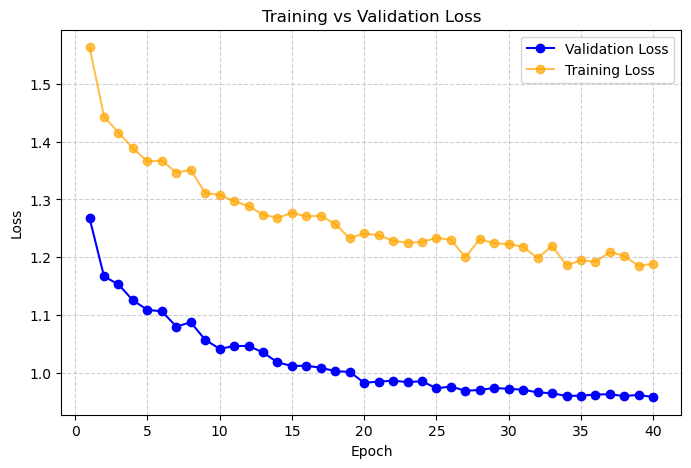

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history["epoch"], history["val_loss"], marker='o', label="Validation Loss", color="blue")
plt.plot(history["epoch"], history["train_loss"], marker='o', label="Training Loss", color="orange", alpha=0.7)

plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


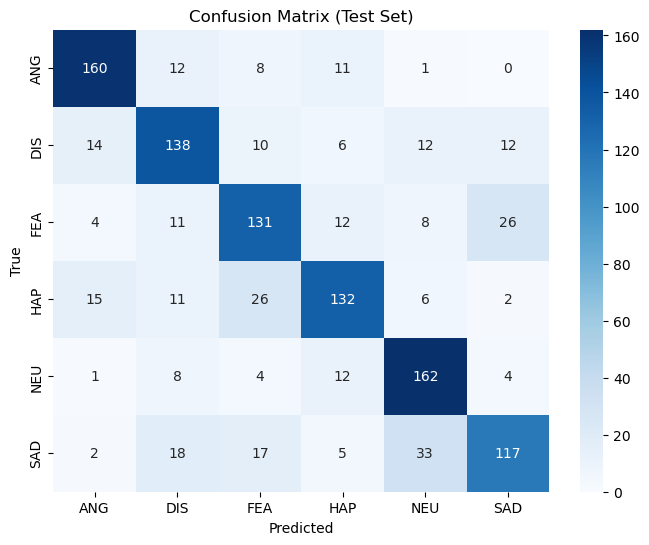

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
classes = [id2label[i] for i in range(len(id2label))]

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)

plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


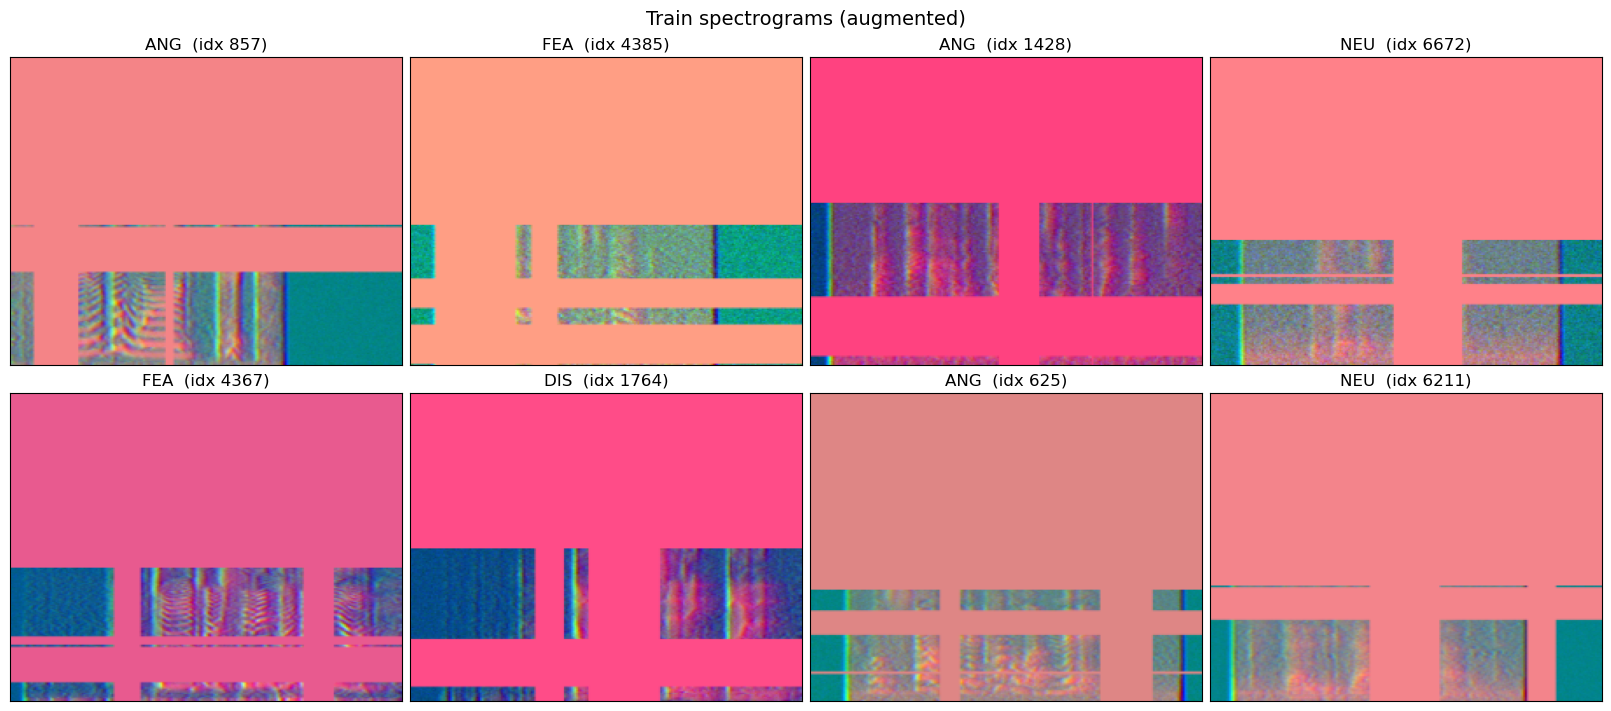

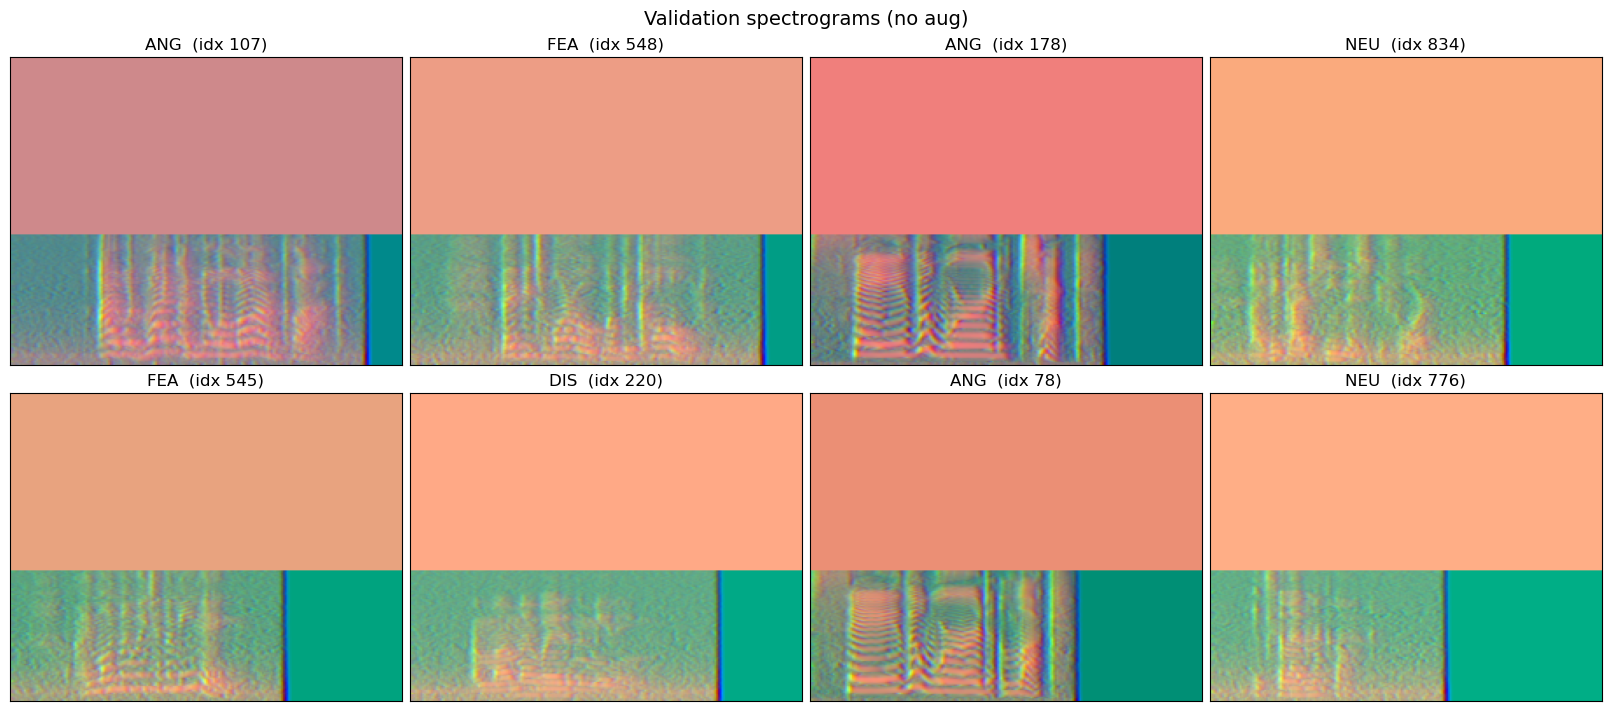

In [ ]:
def denorm_display(spec: torch.Tensor, ds) -> np.ndarray:
    x = spec.clone().float()

    if ds.use_imagenet_norm:
        IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
        x = x * IMAGENET_STD + IMAGENET_MEAN
    elif (ds.global_mean is not None) and (ds.global_std is not None):
        x = x * ds.global_std + ds.global_mean

    x_min = x.amin(dim=(1,2), keepdim=True)
    x_max = x.amax(dim=(1,2), keepdim=True)
    x = (x - x_min) / (x_max - x_min + 1e-8)
    return x.cpu().numpy()

def spectrogram_grid(
    ds,
    id2label: dict[int, str],
    n: int = 8,
    ncols: int = 4,
    seed: int | None = 123,
    title: str = ""
):
    
    if seed is not None:
        random.seed(seed)

    n = min(n, len(ds))
    idxs = random.sample(range(len(ds)), n)

    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.5*nrows), constrained_layout=True)
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1:
        axes = np.array([axes])

    for ax, i in zip(axes.flatten(), idxs):
        spec, label = ds[i]                   
        img = denorm_display(spec, ds)  

        if img.shape[0] == 1:
            ax.imshow(img[0], origin='lower', aspect='auto', cmap='magma')
        else:
            ax.imshow(np.transpose(img, (1,2,0)), origin='lower', aspect='auto')

        ax.set_title(f"{id2label[int(label)]}  (idx {i})")
        ax.set_xticks([]); ax.set_yticks([])

    for j in range(n, nrows*ncols):
        axes.flatten()[j].axis('off')

    if title:
        fig.suptitle(title, fontsize=14)
    plt.show()

spectrogram_grid(train_loader.dataset, id2label, n=8, ncols=4, title="Train spectrograms (augmented)")
spectrogram_grid(val_loader.dataset,   id2label, n=8, ncols=4, title="Validation spectrograms (no aug)")
